In [3]:
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import time
%matplotlib inline

def gen_samples(M):
    p=0.55
    yp=0.66

    pv=np.array([[p**2,2*p*(1-p),(1-p)**2]])
    pv=pv*pv.T
    pv=pv[None,:,:]*np.array([yp,1.0-yp])[:,None,None]
    pv=pv.ravel()
    
    return np.random.multinomial(M,pv).reshape((2,3,3))

def time_theirs(N=20,M=10000,nloop=1):
    # M =  number of samples
    # N =  number of permutations
    dt=0
    #sampling from hypergeometric distribution
    for loopk in range(nloop):
        x0=np.random.rand(2,M)
        #choosing thresholds corresponding to maf=0.6 -- p^2=0.36, p^2+2pq=0.84
        p=0.55
        x0=(x0>(p**2)).astype(int)+(x0>(p**2+2*p*(1-p))).astype(int)
        p0=np.random.rand(M)
        p0=(p0>0.66).astype(int)
        pheno=copy(p0)

        C0=np.zeros((2,3,3))
        for i in range(3):
            for j in range(3):
                for k in range(2):
                    C0[k,i,j]=np.sum((x0[0]==i)&(x0[1]==j)&(pheno==k))
        tic=time.time()
        C1=np.zeros((2,3,3,N))
        for n in range(N):
            np.random.shuffle(p0)
            for i in range(3):
                for j in range(3):
                    for k in range(2):
                        C1[k,i,j,n]=np.sum((x0[0]==i)&(x0[1]==j)&(p0==k))
        dt+=(time.time()-tic)/nloop
    return dt
def time_ours(N=20,M=10000,nloop=1,C0=[]):
    dt=0
    #sampling from hypergeometric distribution
    if C0==[]:
        C0=gen_samples(M)
    tic=time.clock()
    for loopk in range(nloop):
        Nk=(C0.sum(0).ravel()[:,None]*np.ones((1,N))).astype(int)
        Nr=np.sum(Nk,0)[None,:]-np.cumsum(Nk,0)
        np0=(C0[0].sum()*np.ones((N,))).astype(int)
        np1=copy(np0)
        C2=np.zeros(Nk.shape)
        for k in range(Nk.shape[0]):
            C2[k][np1!=0]=np.random.hypergeometric(Nk[k][np1!=0],Nr[k][np1!=0],np1[np1!=0])
            np1=(np0-np.sum(C2,0)).astype(int)
        C2=C2.reshape((1,3,3,N))
        C2=np.vstack([C2,Nk.reshape(1,3,3,N)-C2])
    dt+=(time.clock()-tic)/nloop
    return dt


In [4]:
N=20
M2=np.logspace(2,8,100).astype(int)
MDT2=[]
nloops=100
for n in tqdm(range(nloops)):
    dt2=[]
    np.random.shuffle(M2)
    dt2k=[]
    for k,M in enumerate(M2):
        dt2k.append(time_ours(N=N,M=M))
    dt2k=np.array(dt2k)
    dt2.append(dt2k[np.argsort(M2)])
    MDT2.append(dt2)
M2=M2[np.argsort(M2)]
MDT2m=np.vstack(MDT2).mean(0)

M1=np.logspace(2,5,100).astype(int)
MDT1=[]
for n in tqdm(range(nloops)):
    dt1=[]
    np.random.shuffle(M1)
    dt1k=[]
    for k,M in enumerate(M1):
        dt1k.append(time_theirs(N=N,M=M))
    dt1k=np.array(dt1k)
    dt1.append(dt1k[np.argsort(M1)])
    MDT1.append(dt1)
M1=M1[np.argsort(M1)]
MDT1m=np.vstack(MDT1).mean(0)

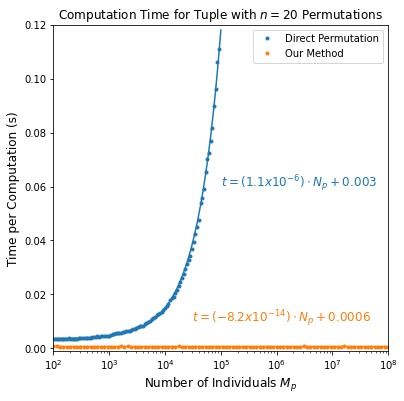

In [6]:
m1,b1=np.polyfit(M1,MDT1m,1)
m2,b2=np.polyfit(M2,MDT2m,1)

plt.figure(figsize=(6,6))

l1,=plt.plot(M1,MDT1m,'.',label='Direct Permutation')
l2,=plt.plot(M2,MDT2m,'.',label='Our Method')
plt.plot(M1,m1*M1+b1,c=l1.get_color())
plt.plot(M2,m2*M2+b2,c=l2.get_color())



#plt.yscale('log')
plt.xscale('log')
plt.legend()



plt.title('Computation Time for Tuple with $n=20$ Permutations')
plt.ylabel('Time per Computation (s)',fontsize=12)
plt.xlabel('Number of Individuals $M_p$',fontsize=12)

e1=int(np.floor(np.log10(m1)))
r1=m1/(10**e1)
plt.text(1e5,0.06,'$t = ({:0.1f}x 10^{{{:}}})\cdot N_p + {:0.3f}$'.format(r1,e1,b1),c=l1.get_color(),fontsize=12)


e2=int(np.floor(np.log10(np.abs(m2))))
r2=m2/(10**e2)
plt.text(3e4,0.01,'$t = ({:0.1f}x 10^{{{:}}})\cdot N_p + {:0.4f}$'.format(r2,e2,b2),c=l2.get_color(),fontsize=12)


plt.xlim(1e2,1e8)
plt.ylim([-0.001,0.12])

plt.savefig('./figs/time_individuals.svg')

In [7]:
# M =  number of samples
# N =  number of permutations

M=100000

N1=np.arange(10,100)
N2=np.logspace(1,5,100).astype(int)
DT1=[]
DT2=[]
nloops=10
for n in tqdm(range(nloops)):
    dt1=[]
    for k,N in enumerate(N1):
        dt1.append(time_theirs(N=N,M=M,nloop=1))
    DT1.append(dt1)

    dt2=[]
    for k,N in enumerate(N2):
        dt2.append(time_ours(N=N,M=M,nloop=1))
    DT2.append(dt2)
DT1m=np.vstack(DT1).mean(0)
DT2m=np.vstack(DT2).mean(0)


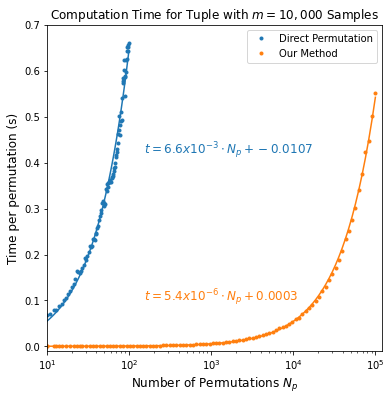

In [12]:
m1,b1=np.polyfit(N1,DT1m,1)
m2,b2=np.polyfit(N2,DT2m,1)

plt.figure(figsize=(6,6))

l1,=plt.plot(N1,DT1m,'.',label='Direct Permutation')
l2,=plt.plot(N2,DT2m,'.',label='Our Method')
plt.plot(N1,m1*N1+b1,c=l1.get_color())
plt.plot(N2,m2*N2+b2,c=l2.get_color())



#plt.yscale('log')
plt.xscale('log')
plt.legend()



plt.title('Computation Time for Tuple with $m=10,000$ Samples')
plt.ylabel('Time per permutation (s)',fontsize=12)
plt.xlabel('Number of Permutations $N_p$',fontsize=12)

e1=int(np.floor(np.log10(m1)))
r1=m1/(10**e1)
plt.text(1.5e2,0.42,'$t = {:0.1f}x 10^{{{:}}}\cdot N_p + {:0.4f}$'.format(r1,e1,b1),c=l1.get_color(),fontsize=12)
#plt.text(5e3,0.42,'$t = {:0.1f}x 10^{{{:}}}\cdot N_p + {:0.4f}$'.format(r1,e1,b1),c=l1.get_color(),fontsize=12)

e2=int(np.floor(np.log10(m2)))
r2=m2/(10**e2)
plt.text(1.5e2,0.1,'$t = {:0.1f}x 10^{{{:}}}\cdot N_p + {:0.4f}$'.format(r2,e2,b2),c=l2.get_color(),fontsize=12)
#plt.text(4e4,0.1,'$t = {:0.1f}x 10^{{{:}}}\cdot N_p + {:0.4f}$'.format(r2,e2,b2),c=l2.get_color(),fontsize=12)

plt.xlim(10,1.2e5)
#plt.xlim(-1e3,1e5)
plt.ylim([-0.01,0.70])

plt.savefig('./figs/time_permutations.svg')